In [2]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

class DataSchema(object):
    def __init__(self, schema):
        schema = schema.split(',')
        self._idx2name = schema
        self._name2idx = dict(((x, y) for (y, x) in enumerate(schema)))    
    def name(self, idx):
        return self._ind2name[idx]
    
    def idx(self, name):
        return self._name2idx[name]

STR_SCHEMA = 'SteerAngle,Throttle,Brake,Speed,X_Position,Y_Position,Pitch,Yaw,Roll'
SCHEMA = DataSchema(STR_SCHEMA)
FRAME_SHAPE = (160, 320)
DST_SIZE = 5
BOTTOM_OFFSET = 6
WORLD_SIZE = 200

FRAME_ORIGIN = (FRAME_SHAPE[1]/2, FRAME_SHAPE[0])

def rover_coords(binary_img):
    # Extract xpos and ypos pixel positions from binary_img and
    # Convert xpos and ypos to rover-centric coordinates
    ypos, xpos = binary_img.nonzero()
    xpos = xpos.astype('float32')
    ypos = ypos.astype('float32')
    nxpos = FRAME_ORIGIN[1] - ypos
    nypos = FRAME_ORIGIN[0] - xpos
    return nxpos, nypos

In [2]:
def load_dataset(path):    
    with open(path) as ip:
        lines = list(ip)
    lines = filter(lambda x: STR_SCHEMA not in x, lines)
    rows = [x.split(',') for x in lines]
    images = [x[0] for x in rows]
    features = [[float(x) for x in row[1:]] for row in rows]
    features = np.array(features, dtype=np.float32)
    
    all_images = None
    for index, img in enumerate(images):
        image = mpimg.imread(img)
        if all_images is None:
            all_images = np.zeros((len(images),) + image.shape, dtype=image.dtype)
        all_images[index] = image
    return features, all_images

In [3]:
features, images = load_dataset('./recorder/2017_MAY_27/robot_log.csv')

In [4]:
def color_thresh(img, rgb_thresh=(0, 0, 0)):
    ####### TODO 
    # Create an empty array the same size in x and y as the image 
        # but just a single channel
    # Apply the thresholds for RGB and 
        # assign 1's where threshold was exceeded
    thresh = np.array(rgb_thresh)
    shape = [1] * img.ndim
    shape[-1] = -1
    thresh.reshape(shape)
    binary_image = img > thresh
    binary_image = np.all(binary_image, axis=-1)
    binary_image = binary_image.astype('uint8')
    return binary_image

def perspect_transform(img, src, dst):

    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image using cv2.warpPerspective()
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the result
    return warped

In [3]:
SOURCE = np.float32([[14.32 , 140.71], [ 120.78, 95.5], [199.49 ,96.84], [302.7 ,140.71]])

TARGET = np.float32([[FRAME_SHAPE[1]/2 - DST_SIZE, 
                      FRAME_SHAPE[0] - BOTTOM_OFFSET],
                  [FRAME_SHAPE[1]/2 - DST_SIZE, 
                   FRAME_SHAPE[0] - BOTTOM_OFFSET - 2 * DST_SIZE],
                  [FRAME_SHAPE[1]/2 + DST_SIZE, 
                   FRAME_SHAPE[0] - BOTTOM_OFFSET - 2 * DST_SIZE], 
                  [FRAME_SHAPE[1]/2 + DST_SIZE, 
                   FRAME_SHAPE[0] - BOTTOM_OFFSET]])

PROJECTION = cv2.getPerspectiveTransform(SOURCE, TARGET)

def const_perspective_transform(imgs):
    ret = np.zeros_like(imgs)
    size = (FRAME_SHAPE[1], FRAME_SHAPE[0])
    for index, img in enumerate(imgs):
        ret[index] = cv2.warpPerspective(img, PROJECTION, size)
    return ret

In [33]:
top_downs = const_perspective_transform(images)

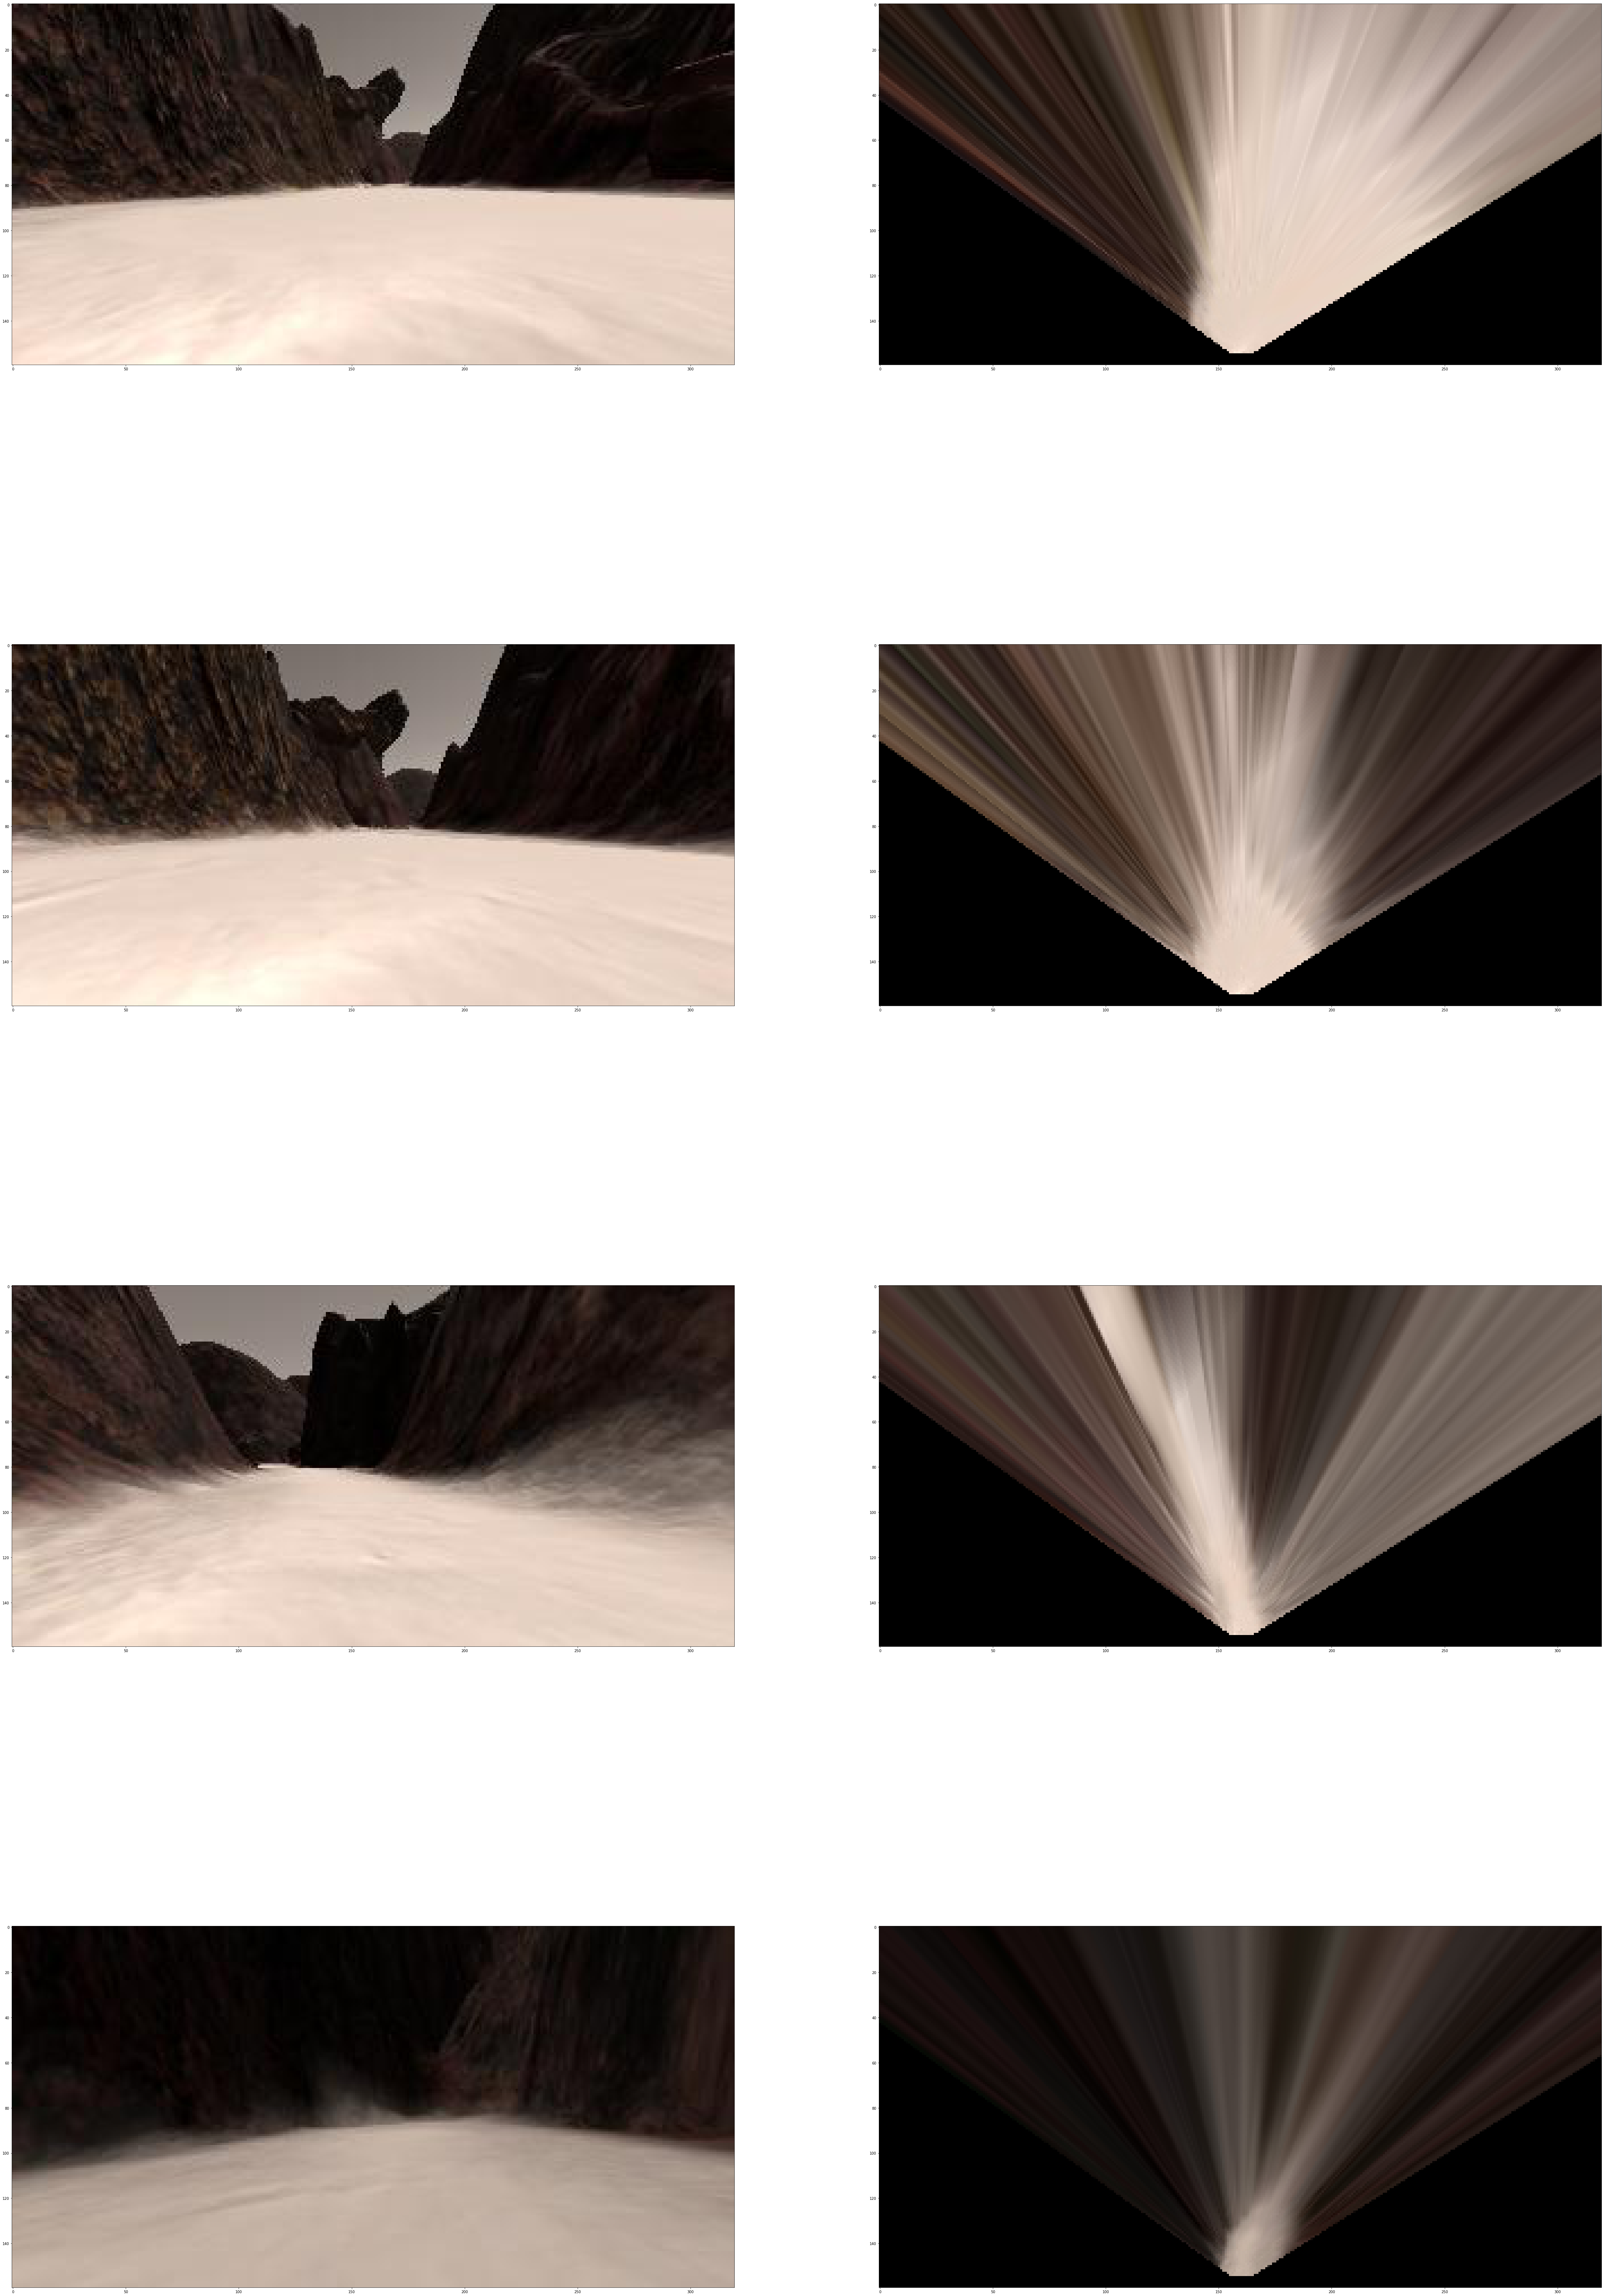

In [45]:
# debug perspective transform
index = 0
fig = plt.figure(figsize=(80,160)) # Create a figure for plotting
plt.subplot(521)
plt.imshow(images[0])
plt.subplot(522)
plt.imshow(top_downs[0])

plt.subplot(523)
plt.imshow(images[300])
plt.subplot(524)
plt.imshow(top_downs[300])

plt.subplot(525)
plt.imshow(images[600])
plt.subplot(526)
plt.imshow(top_downs[600])

plt.subplot(527)
plt.imshow(images[900])
plt.subplot(528)
plt.imshow(top_downs[900])

plt.show()

In [46]:
#tresholding
points = color_thresh(top_downs, rgb_thresh=(160, 160, 160))

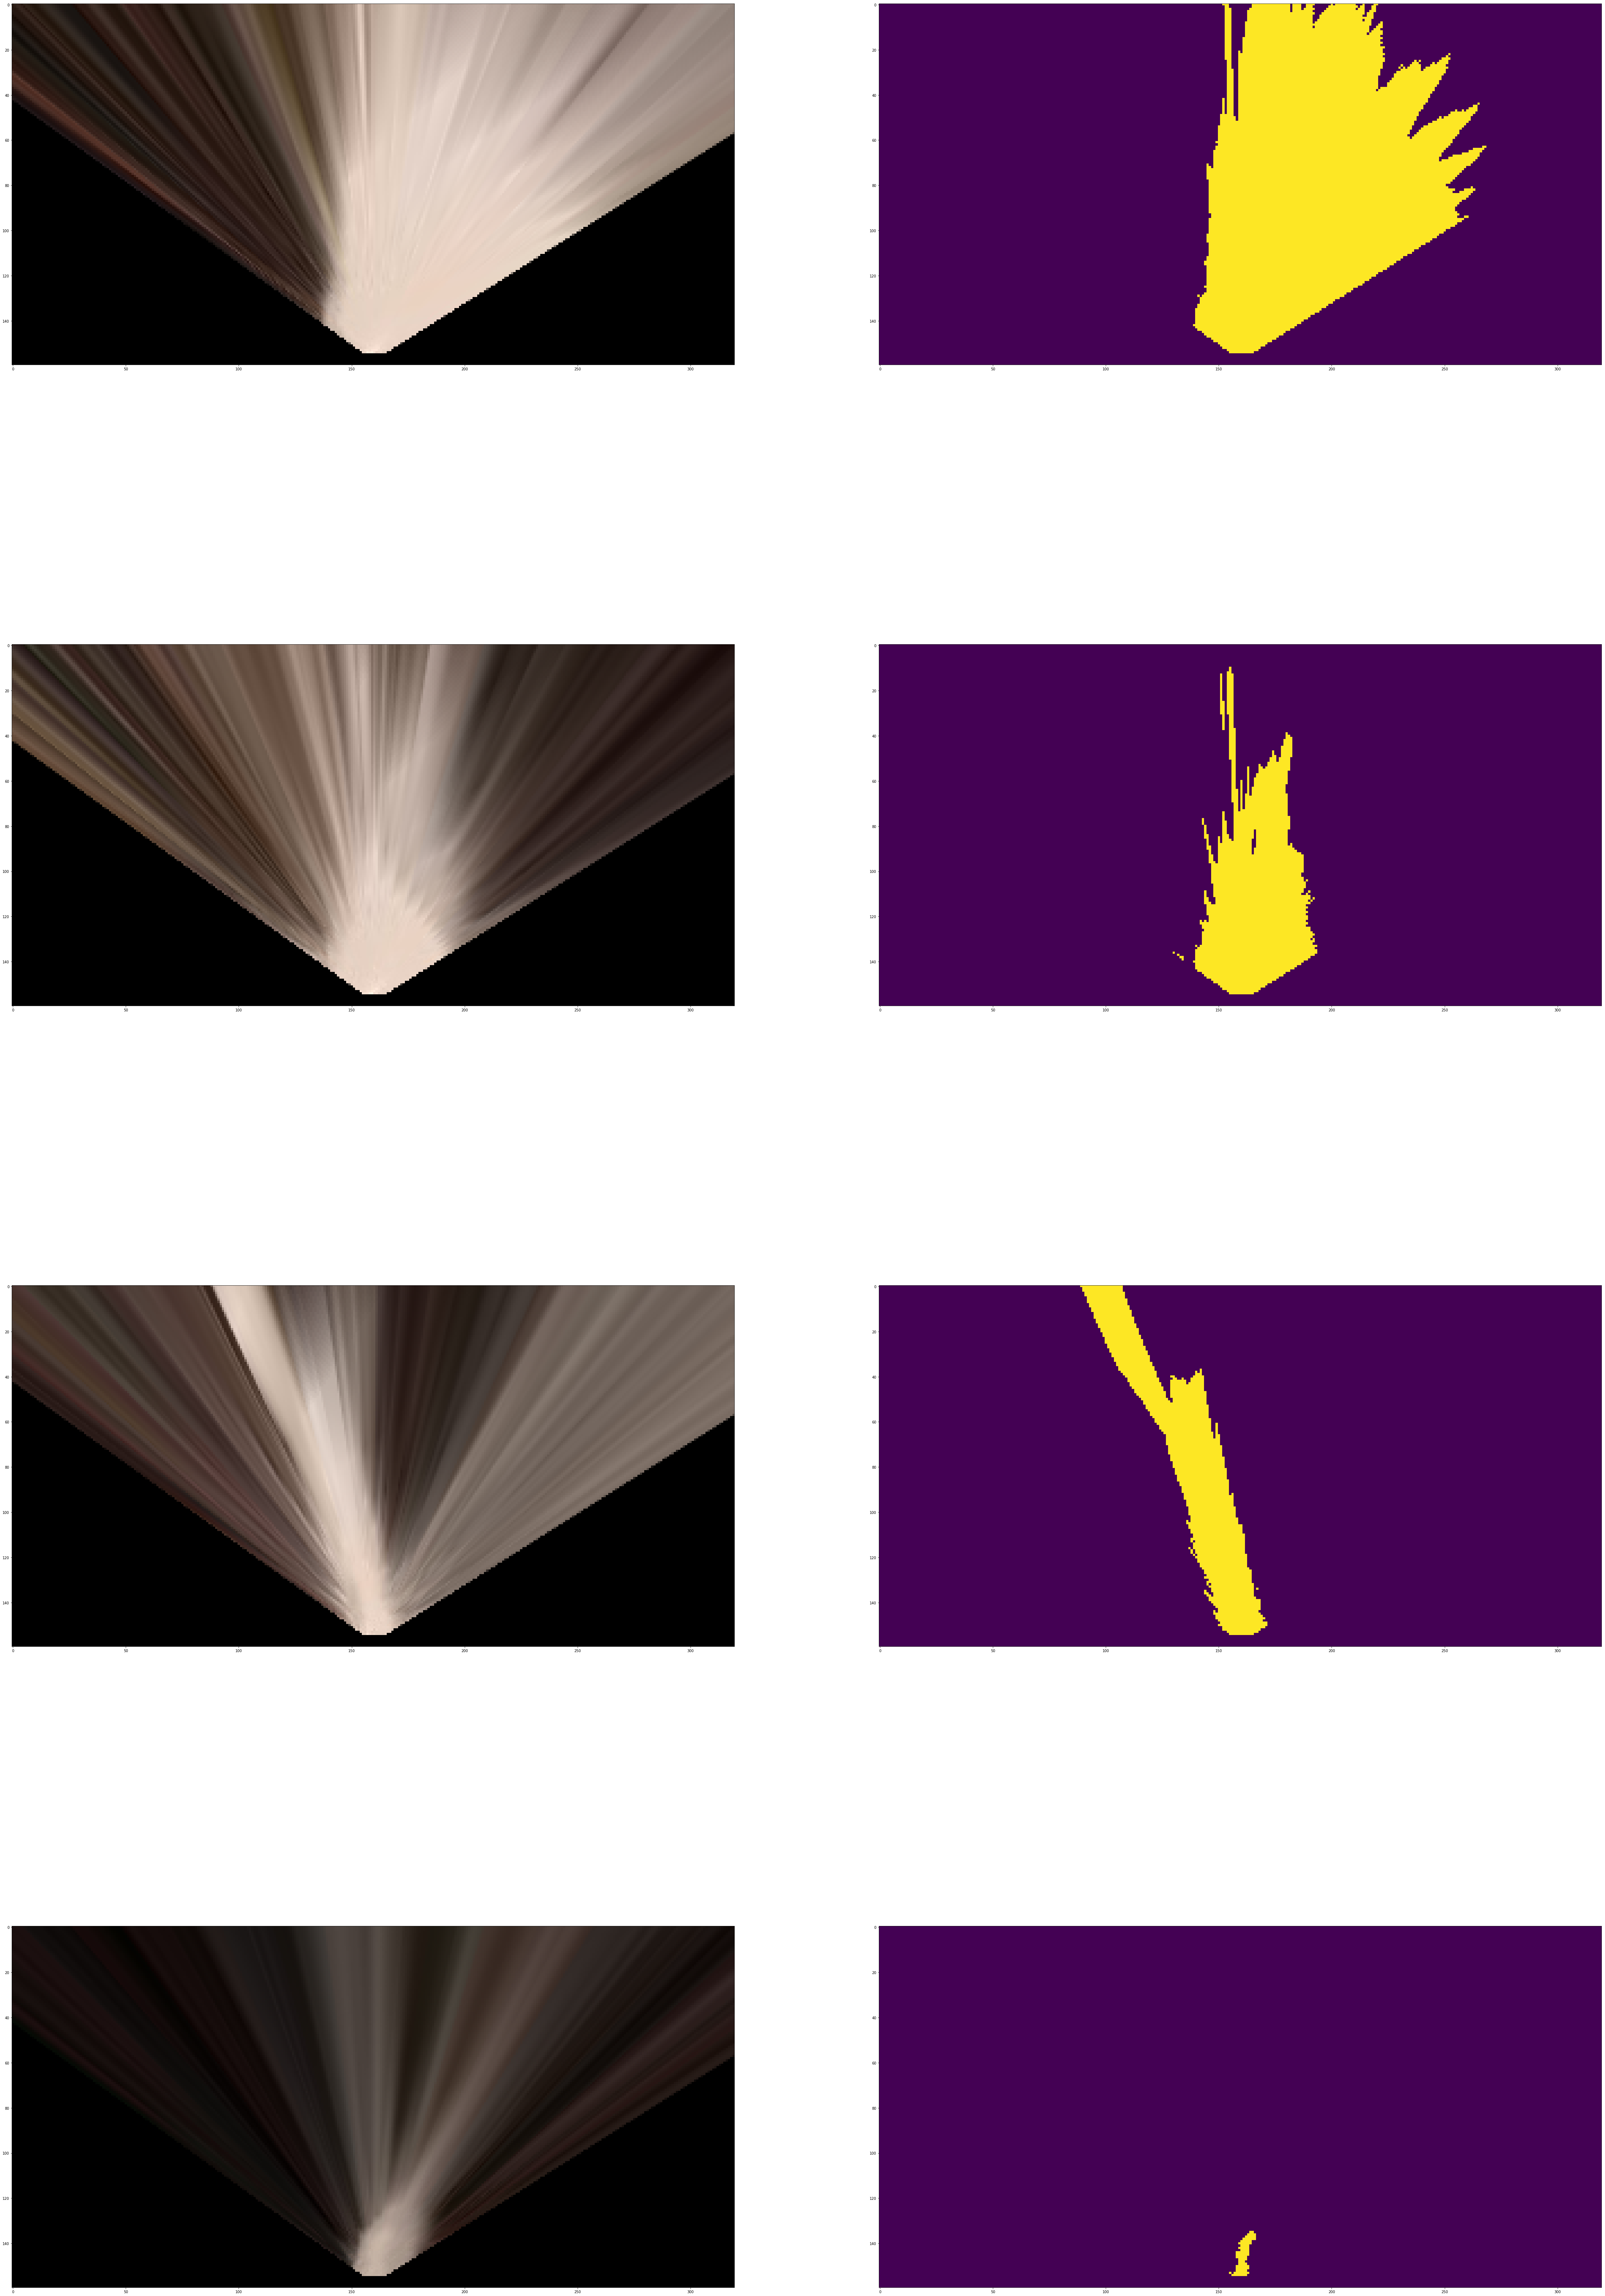

In [47]:
# debug thresholding
index = 0
fig = plt.figure(figsize=(80,160)) # Create a figure for plotting
plt.subplot(521)
plt.imshow(top_downs[0])
plt.subplot(522)
plt.imshow(points[0])

plt.subplot(523)
plt.imshow(top_downs[300])
plt.subplot(524)
plt.imshow(points[300])

plt.subplot(525)
plt.imshow(top_downs[600])
plt.subplot(526)
plt.imshow(points[600])

plt.subplot(527)
plt.imshow(top_downs[900])
plt.subplot(528)
plt.imshow(points[900])

plt.show()

In [132]:
def inverse_rotation_matrix(yaw, batch_major=True):
    yaw = (yaw / 180.0) * np.pi
    ret = np.array([[np.cos(yaw), -np.sin(yaw)], [np.sin(yaw), -np.cos(yaw)]])
    if batch_major and yaw.size > 1:
        axes = tuple(range(ret.ndim))[2:] + (1, 0)
    else:
        axes = tuple(range(ret.ndim))
        axes[:2] = (1, 0)
    ret = np.transpose(ret, axes)
    return ret

def translation(x, y, points):
    points = points.astype('float32')
    points /= 2 * DST_SIZE
    points[0] += x
    points[1] += y
    return points

def clip_coordinates(x):
    ret = np.around(x).astype('uint32')
    ret = np.clip(ret, 0, WORLD_SIZE - 1)
    return ret

In [147]:
# rotation and translation to world frame
particles = [rover_coords(point) for point in points]
rotations = inverse_rotation_matrix(features[:, SCHEMA.idx('Yaw')])
particles = [np.matmul(x, y) for x, y in zip(rotations, particles)]
particles = [translation(x, y, ps) for x, y, ps in zip(
    features[:, SCHEMA.idx('X_Position')], 
    features[:, SCHEMA.idx('Y_Position')], particles)]
particles = [clip_coordinates(x) for x in particles]

In [164]:
# generate world map
worldmap = np.zeros((200, 200))
for pts in particles:
    worldmap[199 - pts[1], pts[0]] += 1

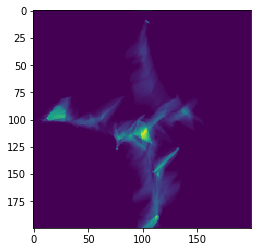

In [167]:
plt.imshow(worldmap)
plt.show()

In [153]:
print(features[1:10, SCHEMA.idx('X_Position')])
print(features[1:10, SCHEMA.idx('Y_Position')])

[ 12.63918972  12.63918972  12.63918972  12.63918972  12.63918972
  12.63918972  12.63918972  12.63918972  12.63918972]
[ 100.38279724  100.38279724  100.38279724  100.38279724  100.38279724
  100.38279724  100.38279724  100.38279724  100.38279724]


In [158]:
print(particles[0][0, :].mean())
print(particles[0][1, :].mean())

21.5117344923
104.519241407


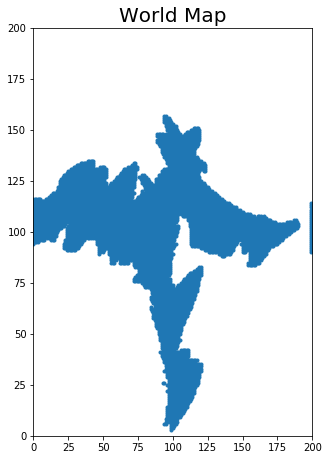

In [159]:
fig = plt.figure(figsize=(5, 7.5))
x_coord, y_coord = worldmap.nonzero()
plt.plot(x_coord, y_coord, '.')
plt.ylim(0, 200)
plt.xlim(0, 200)
plt.title('World Map', fontsize=20)
plt.show()